Для первой задачи мы используем данные [Jester Online Joke Recommender System](https://goldberg.berkeley.edu/jester-data/)

**Описание данных**

Файл `train_joke_df.csv` содержит:
- UID - id пользователей
- JID - id шуток, которые 
- Ratin - рейтинг шутки, который проставил пользователь 


Рейтинг имеет значение от -10.00 до 10.00. Могут встречаться значения 99.00, но это обозначает Null (нет рейтинга от пользователя).

Метрика для оценки [RMSE](https://www.codecamp.ru/blog/how-to-interpret-rmse/)

Минимальный RMSE: `4.2238`



In [6]:
#!pip install "scikit-surprise==1.1.3"

In [7]:
#!pip install "xlrd==2.0.1"

### Import

In [8]:
import numpy as np
import pandas as pd
from collections import defaultdict
from surprise import Dataset, Reader, accuracy
from surprise.model_selection import GridSearchCV
from surprise.model_selection import train_test_split
from sklearn.model_selection import train_test_split as tts
from surprise.model_selection import KFold

import seaborn as sns
from surprise import SVD
np.random.seed(42)

### Базовые функции для скоринга и получения рекомендаций

In [9]:
def get_num_user_ratings(uid):
    """ возвращает кол-во рейтингов у пользователя 
    args: 
      uid: id пользователей
    returns: 
      кол-во объектов, которые оценил пользователь
    """
    try:
        return len(trainset.ur[trainset.to_inner_uid(uid)])
    except ValueError: # пользователя не было во время обучения (новый, отправить на стартовые рекомендации)
        return 0
    
def get_num_item_ratings(iid):
    """ возвращает кол-во пользователей, которые оценили выбранный элемент 
    args:
      iid: строка с элементов рекомендации
    returns:
      кол-во пользователей, которые дали оценки по элементу
    """
    try: 
        return len(trainset.ir[trainset.to_inner_iid(iid)])
    except ValueError:
        return 0
    
# На основе Surprise FAQ построим рекомендации Топ-N
def get_top_n(predictions, n=5):
    """Определят Топ-N рекомендаций

    Args:
        predictions(list of Prediction objects): Списко рекомендаций, из алгоритма Surprise
        n(int): Кол-во топ рекомендаций

    Returns:
        Словарь пользователь - список рекомендакиций для пользователей
        [(raw item id, rating estimation), ...]
    """

    # Предикт для каждого пользователя
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))

    # Сортировка предикта (по пользователям)
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]

    return top_n    

### Загрузка и обработка данных

In [10]:
df = pd.read_csv(r'..\data\recsys-in-practice\train_joke_df.csv')

df.head(5)

,UID,JID,Rating
0,18029,6,-1.26
1,3298,64,-4.17
2,3366,58,0.92
3,12735,92,3.69
4,11365,38,-6.60


In [11]:
# сделаем сортировку и перепишем index
df = df.sort_values(by=['UID', 'JID'])
df = df.reset_index(drop=True)

In [12]:
# создадим на основе набора данных
# поднабор, который требуется для библиотеки Surprise

# указываем минимальный и максимальный рейтинги
reader = Reader(rating_scale=(-10, 10))

# передаём набор, указывая последовательность колонок: user (raw) ids, item (raw) ids, ratings
# для Surprise - это обязательно
data = Dataset.load_from_df(df[['UID', 'JID', 'Rating']], reader)

In [13]:
trainset_data = data.build_full_trainset()

# сделаем разделение на обучающую и тестовую выборку
trainset, testset = train_test_split(data, test_size=0.2, random_state=42)

### Обучение модели

In [15]:

#param_grid = {"n_epochs": [10, 20, 50, 100, 200], "n_factors": [32, 64, 100, 128, 256, 512, 1024],'random_state':[0]}

#gs = GridSearchCV(SVD, param_grid, measures=["rmse", "mae"], cv=2,)
#gs.fit(data)
     
# результат
#print(gs.best_score["rmse"])
#print(gs.best_params["rmse"])

In [ ]:
# обучим с лучшими параметрами
#algo = SVD(random_state=0)
#algo.fit(trainset)

# получим предикт и посмотрим метрику
#predictions = algo.test(testset)
#accuracy.rmse(predictions)

#RMSE: 4.1685

#4.168486060306104

In [16]:
# обучим с лучшими параметрами
algo = SVD(random_state=0, n_epochs=100, n_factors= 512)
algo.fit(trainset)

# получим предикт и посмотрим метрику
predictions = algo.test(testset)
accuracy.rmse(predictions)

RMSE: 4.0689


4.0689312503214765

### Тестирование и результаты

In [17]:
# получаем предикт
uid = 1  # id пользователя 
iid = 1  # iв шутки

# получим предик на основе обученных данных
# -7.82 - это фактический рейтинг, но посмотрим, какой ответ будет в предикте
pred = algo.predict(uid, iid, r_ui=-7.82, verbose=True)

user: 1          item: 1          r_ui = -7.82   est = -7.76   {'was_impossible': False}


In [18]:
uid = 24983  # id пользователя 
iid = 62     # iв шутки

pred = algo.predict(uid, iid, r_ui=-0.29, verbose=True)

user: 24983      item: 62         r_ui = -0.29   est = 0.04   {'was_impossible': False}


### Обзор рекомендаций

In [19]:
# построим таблицу для обзора набора рекомендаций
# посмотрим, какие элементы и в каком кол-ве рекомендуем
trainset = algo.trainset

predictions_df = pd.DataFrame(predictions, columns=['uid', 'iid', 'rui', 'est', 'details'])

predictions_df['№ кол-во пользовательских рейтингов'] = predictions_df.uid.apply(get_num_user_ratings)
predictions_df['№ кол-во рейтингов элементов'] = predictions_df.iid.apply(get_num_item_ratings)
predictions_df['error'] = abs(predictions_df.est - predictions_df.rui)

best_predictions = predictions_df.sort_values(by='error')[:10]
worst_predictions = predictions_df.sort_values(by='error')[-10:]

In [20]:
best_predictions.head(5)

,uid,iid,rui,est,details,№ кол-во пользовательских рейтингов,№ кол-во рейтингов элементов,error
129018,2217,57,0.44,0.440004,{'was_impossible': False},63,10208,0.000004
144941,1247,68,5.34,5.339994,{'was_impossible': False},30,16017,0.000006
50345,4853,43,-3.40,-3.400122,{'was_impossible': False},43,11261,0.000122
227326,13315,88,0.29,0.289870,{'was_impossible': False},62,6204,0.000130
42501,1927,59,1.41,1.409845,{'was_impossible': False},48,11579,0.000155


In [21]:
# Предикт для всех, кого нет в выборке для обучения
testset = trainset.build_anti_testset()
predictions = algo.test(testset)

top_n = get_top_n(predictions)

# Сделаем вывод рекомендаций
a=0
for uid, user_ratings in top_n.items():
    a+=1
    print(uid, [iid for (iid, _) in user_ratings])
    
    if a==10:
        break

19208 [54, 89, 45, 29, 78]
8671 [8, 83, 75, 15, 19]
6037 [76, 78, 89, 27, 36]
3233 [50, 36, 31, 27, 48]
3449 [100, 73, 98, 80, 83]
10032 [91, 29, 35, 76, 49]
5774 [89, 68, 32, 23, 47]
23392 [62, 35, 29, 36, 48]
3039 [62, 27, 53, 89, 91]
17395 [27, 72, 89, 85, 93]


### Для отправки на тестирование

In [22]:
# обучим с лучшими параметрами
#algo = SVD(random_state=0)
#algo.fit(trainset_data)

# получим предикт и посмотрим метрику
#predictions = algo.test(trainset_data.build_testset())
#accuracy.rmse(predictions)

#RMSE: 0.5627

#0.5626765215970747

In [23]:
# обучим с лучшими параметрами
algo = SVD(random_state=0, n_epochs=100, n_factors= 512)
algo.fit(trainset_data)

# получим предикт и посмотрим метрику
predictions = algo.test(trainset_data.build_testset())
accuracy.rmse(predictions)

RMSE: 0.2524


0.25238153948056485

In [24]:
test = pd.read_csv(r'..\data\recsys-in-practice\test_joke_df_nofactrating.csv', index_col=0)
test.head(5)

,UID,JID
InteractionID,,
0,11228,39
1,21724,85
2,16782,56
3,12105,42
4,14427,2


In [25]:
test['Rating'] = test[['UID', 'JID']].apply(lambda x: algo.predict(x[0], x[1], verbose=False).est,
                                                      axis = 1)
                                                      


In [26]:
# вид набора данных, который должен быть отправлен для тестирования
test['Rating'].to_frame().head(5)

,Rating
InteractionID,
0,3.042851
1,-7.039993
2,-0.331728
3,6.796138
4,5.779301


In [27]:
# формирование файла для отправки в Kaggle
test['Rating'].to_frame().to_csv('baseline_svd_tuning_best_4.02408.csv')

C:\Temp\ipykernel_10460\3093547129.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(test['Rating'])


<AxesSubplot:xlabel='Rating', ylabel='Density'>

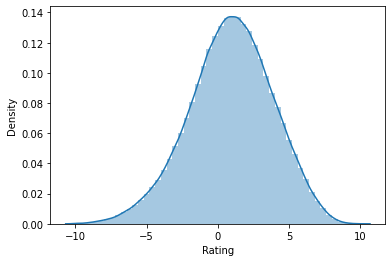

In [28]:
sns.distplot(test['Rating'])

In [29]:
solution = pd.read_csv('baseline_svd_tuning_best_4.02408.csv')

In [30]:
def correct(x):
    x2 = round(np.abs(x))
    r = 0
    if x2 == 0: r = 1
    if x2 == 1: r = 1
    if x2 == 2: r = 1
    elif x2 == 3: r = 0.9
    elif x2 == 4: r = 0.8
    elif x2 == 5: r = 0.7
    elif x2 == 6: r = 0.6
    elif x2 == 7: r = 0.5
    elif x2 == 8: r = 0.4
    elif x2 == 9: r = 0.3
    return x + r * np.sign(x)

In [31]:
test['Rating'] = solution['Rating'].apply(correct)
test

,UID,JID,Rating
InteractionID,,,
0,11228,39,3.942851
1,21724,85,-7.539993
2,16782,56,-1.331728
3,12105,42,7.296138
4,14427,2,6.379301
...,...,...,...
362086,3085,66,-1.540293
362087,13765,31,3.404859
362088,10341,29,5.552438


In [32]:
test['Rating'].to_frame().head(5)

,Rating
InteractionID,
0,3.942851
1,-7.539993
2,-1.331728
3,7.296138
4,6.379301


In [33]:
test['Rating'].to_frame().to_csv('solution.csv')

C:\Temp\ipykernel_10460\1495490845.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df['Rating'])
C:\Temp\ipykernel_10460\1495490845.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(solution['Rating'])


KeyError: 'Rating2'

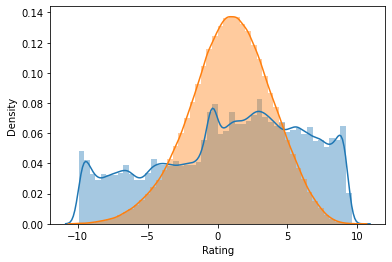

In [34]:

sns.distplot(df['Rating'])
sns.distplot(solution['Rating'])

In [35]:
algo.predict(11228, 39, verbose=False)

Prediction(uid=11228, iid=39, r_ui=None, est=3.0428512748956713, details={'was_impossible': False})

In [36]:
algo.estimate(u=11228, i=39)

-1.434611076709447

In [37]:
algo.bi[:10], algo.bu[:10]

(array([ 0.31033319, -0.38314812, -0.08525166, -1.24617922, -0.24116796,
         0.29776527, -0.65546489, -0.85163282, -0.70304173,  0.45724906]),
 array([-1.68376186,  0.5438339 ,  2.02106013,  0.51446725,  0.67149867,
        -2.30392862,  1.19760621, -1.23214924, -0.82893065,  1.30338976]))

In [38]:
algo.pu.shape, algo.qi.shape

((24983, 512), (100, 512))

In [39]:
algo.pu[:10, :10]

array([[-2.86540909e-01,  1.04682178e-01, -4.40082676e-02,
        -2.78974646e-01,  1.55769587e-01,  2.33472301e-01,
        -2.90557384e-01,  1.25727306e-01, -6.00099210e-02,
         4.33443298e-01],
       [ 1.00130047e-01,  1.11911840e-02,  1.80694479e-01,
         5.76512181e-02, -5.06843480e-01, -4.76710669e-03,
        -2.03006176e-01,  4.81218886e-01, -1.14859621e-01,
        -7.97198521e-01],
       [-1.04715753e-02,  1.73412797e-01, -1.86219941e-01,
         2.50241689e-02,  2.61903041e-02,  1.22564945e-01,
        -2.08922939e-01,  4.23749869e-02,  1.12724775e-02,
         1.93108593e-01],
       [ 7.39884797e-02, -3.54489662e-01,  2.72771052e-01,
        -1.08249569e-01,  1.12400044e-01,  1.28777192e-01,
        -3.50327757e-01, -5.84792905e-03, -3.83755907e-01,
         1.19397693e-01],
       [ 5.46110149e-02,  2.10468622e-01,  8.70760855e-02,
        -2.20986971e-01, -1.72452039e-01,  5.37873306e-02,
        -1.55922221e-01, -2.53234396e-01, -3.04765883e-01,
         4.

In [40]:
algo.qi[:10, :10]

array([[ 1.42092474e-01,  1.61276209e-01, -8.58432291e-02,
         1.40841410e-01,  1.15382942e-01,  2.60779834e-01,
        -2.67846035e-01, -1.28507405e-01, -3.11427432e-01,
         2.61877555e-01],
       [-2.06023366e-01, -3.68222652e-01, -2.53905255e-01,
         1.28672021e-01,  5.88190220e-01,  1.17129196e-01,
        -5.86125184e-01,  3.78145352e-02, -6.39655282e-01,
        -1.37629416e-01],
       [ 1.48906944e-01,  1.16978034e-01,  8.68937448e-02,
        -2.57897090e-01, -2.50732684e-01, -2.47545169e-01,
         2.18251764e-01, -3.54962425e-02, -1.69172808e-01,
        -2.03568401e-01],
       [ 2.53485234e-02,  1.69686558e-01, -8.10586376e-02,
        -3.83575563e-01,  8.83551505e-02, -1.08314318e-01,
        -4.81364792e-02, -1.27589511e-01, -4.72955745e-01,
        -2.93192461e-01],
       [ 2.01929898e-01, -4.43162738e-01, -1.94423166e-01,
         4.80267173e-01,  1.20569405e-01, -3.75769156e-01,
         1.02972785e-01, -2.15261316e-01, -1.43594167e-01,
         1.

In [41]:
#r_ui = q_i.T * p_u

In [44]:
joke_df = pd.DataFrame(algo.qi, index=np.arange(1, 101), columns=[f'joke_feature_{i}' for i in np.arange(1, 513)])
joke_df

,joke_feature_1,joke_feature_2,joke_feature_3,joke_feature_4,joke_feature_5,joke_feature_6,joke_feature_7,joke_feature_8,joke_feature_9,joke_feature_10,...,joke_feature_503,joke_feature_504,joke_feature_505,joke_feature_506,joke_feature_507,joke_feature_508,joke_feature_509,joke_feature_510,joke_feature_511,joke_feature_512
1,0.142092,0.161276,-0.085843,0.140841,0.115383,0.260780,-0.267846,-0.128507,-0.311427,0.261878,...,-0.086997,0.642238,0.129015,0.137358,0.031935,-0.369892,-0.098020,0.174669,0.188299,-0.188564
2,-0.206023,-0.368223,-0.253905,0.128672,0.588190,0.117129,-0.586125,0.037815,-0.639655,-0.137629,...,-0.178951,-0.149339,-0.510708,0.149664,0.414782,-0.469664,-0.292359,0.120598,0.159565,-0.283802
3,0.148907,0.116978,0.086894,-0.257897,-0.250733,-0.247545,0.218252,-0.035496,-0.169173,-0.203568,...,0.171719,0.440527,0.922526,0.039237,0.331373,0.179839,-0.060934,0.573456,-0.198039,0.014901
4,0.025349,0.169687,-0.081059,-0.383576,0.088355,-0.108314,-0.048136,-0.127590,-0.472956,-0.293192,...,0.275108,0.134429,0.122094,-0.077651,0.137801,0.119666,-0.254773,0.038136,0.047085,-0.437655
5,0.201930,-0.443163,-0.194423,0.480267,0.120569,-0.375769,0.102973,-0.215261,-0.143594,0.168540,...,0.055489,0.004459,0.147334,-0.039287,-0.045829,-0.257551,-0.128635,-0.047791,-0.077637,-0.079604
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96,0.038310,-0.320784,-0.398948,-0.105061,-0.323993,0.033493,-0.199585,-0.163368,0.033929,-0.117046,...,-0.073269,-0.095354,-0.421509,0.094863,0.302751,-0.086174,0.244086,-0.298745,-0.548658,0.063677
97,-0.077509,-0.022602,0.060548,0.197736,0.184115,0.081155,-0.053317,0.247596,0.491517,0.059379,...,0.053112,0.233028,-0.527038,-0.171914,-0.148308,-0.289133,0.408143,-0.086640,0.042957,0.294954
98,0.075268,0.170505,0.047921,-0.148171,-0.248123,0.540658,0.578694,-0.504111,0.269925,-0.383362,...,0.389070,0.249536,0.481943,0.394409,-0.178223,0.342982,0.091326,0.447302,0.327257,-0.482502
99,-0.205066,0.158408,0.120122,0.010672,0.282904,-0.064747,-0.141366,-0.141666,-0.273635,0.256025,...,-0.130165,-0.105244,0.359539,-0.736978,0.240493,-0.314474,0.229752,-0.344169,0.072157,0.038428


In [45]:
joke_df.to_csv('joke_df_features_svd_best_4.02408.csv', index=False)

In [47]:
user_df = pd.DataFrame(algo.pu, index=np.arange(1, 24984), columns=[f'user_feature_{i}' for i in np.arange(1, 513)])
user_df

,user_feature_1,user_feature_2,user_feature_3,user_feature_4,user_feature_5,user_feature_6,user_feature_7,user_feature_8,user_feature_9,user_feature_10,...,user_feature_503,user_feature_504,user_feature_505,user_feature_506,user_feature_507,user_feature_508,user_feature_509,user_feature_510,user_feature_511,user_feature_512
1,-0.286541,0.104682,-0.044008,-0.278975,0.155770,0.233472,-0.290557,0.125727,-0.060010,0.433443,...,0.187660,-0.748804,0.184476,0.437187,0.107889,-0.386573,-0.215301,0.357517,-0.005902,0.169848
2,0.100130,0.011191,0.180694,0.057651,-0.506843,-0.004767,-0.203006,0.481219,-0.114860,-0.797199,...,0.103556,0.374058,-0.003225,0.082901,0.224330,0.023630,0.253504,0.111037,0.059824,-0.254858
3,-0.010472,0.173413,-0.186220,0.025024,0.026190,0.122565,-0.208923,0.042375,0.011272,0.193109,...,0.267017,-0.108724,-0.008937,0.367659,0.119576,0.035629,-0.114915,0.355590,-0.436345,-0.123203
4,0.073988,-0.354490,0.272771,-0.108250,0.112400,0.128777,-0.350328,-0.005848,-0.383756,0.119398,...,0.438087,-0.234654,0.201837,-0.028444,0.190255,0.083467,-0.268704,0.154939,-0.172352,0.211647
5,0.054611,0.210469,0.087076,-0.220987,-0.172452,0.053787,-0.155922,-0.253234,-0.304766,0.407663,...,-0.192879,0.172597,0.106194,0.043944,-0.095593,-0.311244,0.158506,-0.330597,-0.037131,0.581990
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24979,-0.204535,0.201597,0.330617,-0.694725,0.001912,0.267243,-0.305405,0.056835,-0.128771,0.093763,...,0.095866,0.020649,-0.717700,-0.003190,0.958830,-0.228004,-0.187103,-0.086593,0.137313,0.452712
24980,-0.123892,0.542251,0.094026,0.517962,-0.226276,0.479779,0.424285,0.023049,0.123218,-0.272921,...,0.125407,-0.332979,0.596783,0.098348,0.029290,0.408383,-0.144344,1.065045,1.042894,-0.214078
24981,0.266890,0.191195,-0.456191,-0.030366,-0.217968,-0.054737,0.234432,0.257438,0.104117,0.123815,...,0.167595,0.290841,0.253620,0.184360,0.042521,0.419433,-0.132864,-0.022923,0.537218,-0.084455
24982,0.191638,0.176592,-0.300390,-0.022184,-0.241778,-0.259135,-0.072225,0.680874,-0.148201,-0.854220,...,-0.270552,0.028185,-0.092904,0.351073,0.032425,-0.193008,0.072129,-0.150102,0.583104,-0.078574


In [48]:
user_df.to_csv('user_df_features_svd_best_4.02408.csv', index=False)

In [49]:
df_features = df.merge(user_df, left_on='UID', right_index=True).merge(joke_df, left_on='JID', right_index=True)
df_features

,UID,JID,Rating,user_feature_1,user_feature_2,user_feature_3,user_feature_4,user_feature_5,user_feature_6,user_feature_7,...,joke_feature_503,joke_feature_504,joke_feature_505,joke_feature_506,joke_feature_507,joke_feature_508,joke_feature_509,joke_feature_510,joke_feature_511,joke_feature_512
0,1,1,-7.82,-0.286541,0.104682,-0.044008,-0.278975,0.155770,0.233472,-0.290557,...,-0.086997,0.642238,0.129015,0.137358,0.031935,-0.369892,-0.098020,0.174669,0.188299,-0.188564
62,2,1,4.08,0.100130,0.011191,0.180694,0.057651,-0.506843,-0.004767,-0.203006,...,-0.086997,0.642238,0.129015,0.137358,0.031935,-0.369892,-0.098020,0.174669,0.188299,-0.188564
226,5,1,8.50,0.054611,0.210469,0.087076,-0.220987,-0.172452,0.053787,-0.155922,...,-0.086997,0.642238,0.129015,0.137358,0.031935,-0.369892,-0.098020,0.174669,0.188299,-0.188564
578,10,1,3.01,-0.135300,-0.061253,0.110777,0.110683,-0.115111,0.080347,-0.066932,...,-0.086997,0.642238,0.129015,0.137358,0.031935,-0.369892,-0.098020,0.174669,0.188299,-0.188564
643,11,1,-2.91,-0.093135,0.120376,-0.114751,0.081270,-0.131483,-0.265416,0.113452,...,-0.086997,0.642238,0.129015,0.137358,0.031935,-0.369892,-0.098020,0.174669,0.188299,-0.188564
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1447088,24959,75,-2.38,0.220270,-0.027020,0.103505,-0.254154,0.112541,0.153324,-0.082309,...,0.028936,-0.513462,0.056351,0.293027,0.426814,-0.437927,-0.103398,-0.297193,-0.245112,-0.058789
1447277,24963,75,-6.80,0.080809,-0.434816,0.825751,0.219109,0.202813,-0.108498,-0.009693,...,0.028936,-0.513462,0.056351,0.293027,0.426814,-0.437927,-0.103398,-0.297193,-0.245112,-0.058789
1447442,24966,75,2.91,0.168680,0.106525,0.014566,-0.152262,-0.102457,0.026825,-0.021076,...,0.028936,-0.513462,0.056351,0.293027,0.426814,-0.437927,-0.103398,-0.297193,-0.245112,-0.058789
1447808,24972,75,-3.98,-0.138008,0.295111,-0.097380,0.101352,-0.301799,0.262305,0.093549,...,0.028936,-0.513462,0.056351,0.293027,0.426814,-0.437927,-0.103398,-0.297193,-0.245112,-0.058789


In [50]:
df_features.to_csv('df_features_svd_best_4.02408.csv', index=False)


KeyboardInterrupt



In [ ]:
df_test_features = test.merge(user_df, left_on='UID', right_index=True).merge(joke_df, left_on='JID', right_index=True)
df_test_features

In [ ]:
df_test_features.to_csv('df_test_features_svd_best_4.02408.csv')